# Objective - To rank potential talents sources using search keywords and re-rank when a candidate is starred

## Background

As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

Import relevant libraries

In [1]:
import warnings
import os
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import WordNetLemmatizer
# scipy
from scipy.spatial.distance import cosine
# gensim
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
# BERT
from sentence_transformers import SentenceTransformer
# random
import random
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Ignore warnings
warnings.filterwarnings('ignore')

C:\Users\Anant Gupta\Anaconda3\envs\vpt\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# Initial settings
os.chdir(r"C:\Users\Anant Gupta\Apziva\Potential Talents")
pd.set_option('display.max_colwidth', None)
get_ipython().run_line_magic('matplotlib', 'inline')

# Exploratory Data Analysis

Exploring dataset to understand the data

In [3]:
pt = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')
print("Shape of dataframe:", pt.shape)
pt.head()

Shape of dataframe: (104, 5)


,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


Check for duplicate rows

In [4]:
# Drop fit column and explore duplicate rows
pt.drop('fit', axis = 1, inplace = True)             
pt_dup = pt.drop(['id'], axis = 1)                    
print("Number of duplicate entries:", pt_dup.duplicated().sum())                            

Number of duplicate entries: 51


In [5]:
# See duplicate entries
pt[pt_dup.duplicated(keep=False)]                     

,id,job_title,location,connection
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+
...,...,...,...,...
60,61,HR Senior Specialist,San Francisco Bay Area,500+
61,62,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+
62,63,Student at Chapman University,"Lake Forest, California",2
63,64,"SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR","Houston, Texas Area",500+


Number of duplicate rows are 51. We'll now remove duplicate entries.

In [6]:
# Drop duplicate rows and rebuild dataframe
pt_dup = pt_dup.drop_duplicates()                                    
pt = pd.concat([pt['id'], pt_dup], axis = 1).dropna(axis = 0)   
print("Shape of non-duplicated dataframe:", pt.shape)                                                         

Shape of non-duplicated dataframe: (53, 4)


We have now removed duplicate rows from the dataframe.

In [7]:
# Information about the dataframe
pt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 0 to 103
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          53 non-null     int64 
 1   job_title   53 non-null     object
 2   location    53 non-null     object
 3   connection  53 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.1+ KB


In [8]:
# Summary of the dataframe
pt.describe(include = 'all')

,id,job_title,location,connection
count,53.000000,53,53,53
unique,NaN,52,41,33
top,NaN,Aspiring Human Resources Professional,"Houston, Texas Area",500+
freq,NaN,2,4,18
mean,65.132075,NaN,NaN,NaN
std,35.117954,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,28.000000,NaN,NaN,NaN
50%,78.000000,NaN,NaN,NaN
75%,91.000000,NaN,NaN,NaN


There are no null values in the input columns. Total rows in the dataset are 53.

# Data cleaning

Clean data to make it easy to process and more robust

In [9]:
# Text normalization - Replace 'HR' by 'Human Resources' to make our model smarter
pt['cleaned_job_title'] = pt['job_title'].str.replace("HR", " Human Resources ")   

# Removing unnecssary characters like pipes, comma, dot etc. for cleaning the data.
pt['cleaned_job_title'] = pt['cleaned_job_title'].str.replace(r"[^a-zA-Z0-9\' ']", "")
pt['cleaned_job_title'] = pt['cleaned_job_title'].str.lower()
pt = pt.reset_index(drop = True)
pt.head()

,id,job_title,location,connection,cleaned_job_title
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,2019 ct bauer college of business graduate magna cum laude and aspiring human resources professional
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,native english teacher at epik english program in korea
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resources professional
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator at ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member at celal bayar university


In [10]:
# Remove stop words and lemmatize words in cleaned job title
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

for i in range (0, len(pt)):
    word_tokens = word_tokenize(pt['cleaned_job_title'][i])
    filtered_sentence = [w for w in word_tokens if w not in stop_words]
    lemmatized_sentence = []
    for word in filtered_sentence:
        lemmatized_sentence.append(lemmatizer.lemmatize(word))
    pt['cleaned_job_title'][i] = TreebankWordDetokenizer().detokenize(lemmatized_sentence)

pt.head()

,id,job_title,location,connection,cleaned_job_title
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,2019 ct bauer college business graduate magna cum laude aspiring human resource professional
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,native english teacher epik english program korea
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member celal bayar university


# Vectorize job title using TF-IDF

Convert cleaned job titles into vectors 

In [11]:
# Convert job_title column into a list
job_title_list = list(pt['cleaned_job_title'])                    

# Vectorize job_title_list
vectorizer = TfidfVectorizer()                                 
vectorizer.fit(job_title_list)                    
X = vectorizer.transform(job_title_list)                   

In [12]:
# Get feature names in all the documents
feature_names = vectorizer.get_feature_names()                  
print("Number of unique features: ", len(feature_names))        

Number of unique features:  177


In [13]:
# Convert job titles into arrays
tfidf_vector = X.toarray()                                  
print("Shape of Tfidf vector: ", tfidf_vector.shape)        

Shape of Tfidf vector:  (53, 177)


# Cosine Similarity

Calculate cosine similarity between document and the searched phrase

In [14]:
# Searched phrase
phrase = 'Aspiring human resources'

In [15]:
# Define cosine similarity function (cosine gives cosine distance)
def cosine_similarity(vector_1, vector_2):
    cos_sim = 1 - cosine(vector_1, vector_2)        
    return cos_sim

In [16]:
# Lemmatize searched phrase
lemmatized_phrase = []
tokenized_phrase = word_tokenize(phrase.lower())
for word in tokenized_phrase:
    lemmatized_phrase.append(lemmatizer.lemmatize(word))
lemmatized_phrase = TreebankWordDetokenizer().detokenize(lemmatized_phrase)

# Convert search phrase into a vector
X1 = vectorizer.transform([lemmatized_phrase])                    
X1_vector = X1.toarray()
print("Shape of search phrase vector:", X1_vector.shape)

Shape of search phrase vector: (1, 177)


In [17]:
# Calcualte Tfidf cosine similarity and add it to pt dataframe
sim_score_list = []
for x in range (0, len(pt)):
    sim_score_list.append(cosine_similarity(tfidf_vector[x], X1_vector))

pt['tfidf_sim_score'] = sim_score_list
pt.sort_values(by ='tfidf_sim_score', ascending = False).head()

,id,job_title,location,connection,cleaned_job_title,tfidf_sim_score
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.766333
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.766333
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.674875
21,73,"Aspiring Human Resources Manager, seeking internship in Human Resources.","Houston, Texas Area",7,aspiring human resource manager seeking internship human resource,0.609698
12,27,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,aspiring human resource management student seeking internship,0.428269


# Word Embedding

Word embedding "embeds" a word in a cluster of words based on how similar it is to all of the words in the cluster. We'll look at two types of word embedding models (GloVe and Word2Vec) and compute similarity scores between the searched phrase and the documents.

## a. GloVe (Global Vectors)

In GloVe, we measure the similarity of the hidden factors between words to predict their co-occurrence count. I am using a corpus from https://nlp.stanford.edu/projects/glove/ website.

In [18]:
# Create temp file and save converted embedding into it
target_file = get_tmpfile('word2vec.6B.50d.txt')
glove2word2vec('glove.6B.50d.txt', target_file) 

# Load the converted embedding into memory
glove_model = KeyedVectors.load_word2vec_format(target_file)

# Save as binary data
glove_model.save_word2vec_format('word2vec.6B.50d.bin.gz', binary=True)

In [19]:
# Define a function to vectorize a sentence's words
def doc_token_vectors(sentence, model, sentence_vector_list, vector_dimensions):
    word_tokens = word_tokenize(sentence)
    filtered_words = [w for w in word_tokens if w in model.key_to_index.keys()]
    
    for j in range(0, len(word_tokens)):
        if word_tokens[j] in filtered_words:
            token_vector = model[word_tokens[j]]
        else:
            token_vector = np.zeros(vector_dimensions)
        sentence_vector_list.append(token_vector)
    
    return sentence_vector_list

In [20]:
# Vectorize job title using GloVe model
glove_vectors = []
for i in range(0, len(pt)):
    glove_sentence_vector = []
    doc_token_vectors(pt['cleaned_job_title'][i], glove_model, glove_sentence_vector, 50)
    glove_vectors.append(glove_sentence_vector)

In [21]:
# Vectorize searched phrase using GloVe model
glove_search_phrase_vector = []
doc_token_vectors(lemmatized_phrase, glove_model, glove_search_phrase_vector, 50)

[array([-4.3762e-01,  8.3236e-01,  2.9638e-01, -7.8180e-01,  2.4432e-01,
         3.2892e-01, -8.2750e-01,  1.2692e-01, -3.9246e-01,  8.6643e-01,
         2.4300e-01, -6.6664e-04,  5.2488e-01,  1.5963e+00,  3.8362e-01,
        -3.2021e-01,  1.0324e+00,  7.0235e-01,  4.1679e-01, -2.0262e-01,
         2.8378e-01,  9.4354e-01, -3.4941e-01,  1.4981e+00,  3.2488e-01,
        -6.6963e-01, -4.2229e-01, -1.3033e+00, -5.9413e-01, -7.0466e-02,
         7.0193e-01,  3.0914e-01, -4.0663e-01, -6.4972e-01,  7.7279e-01,
         3.3412e-01, -8.0891e-01,  2.4861e-02, -5.1049e-01, -8.1757e-01,
        -1.0251e-01,  5.6904e-01,  6.7411e-01, -1.9030e-01,  4.0583e-01,
        -6.1531e-01,  2.2660e-01, -1.1493e-03, -6.5260e-01,  1.8631e-01],
       dtype=float32),
 array([ 0.61854 ,  0.11915 , -0.46786 ,  0.31368 ,  1.0334  ,  0.95964 ,
         0.87803 , -1.0346  ,  1.6322  ,  0.29347 ,  0.80844 , -0.058903,
         0.021251,  0.40986 ,  0.54443 , -0.33311 ,  0.53712 , -0.35823 ,
         0.29374 ,  0.09

In [22]:
# Calculate cosine similarity between searched phrase and job title
glove_similarity =[]
for i in range(0, len(pt)):
    sim_score = cosine_similarity(np.mean(glove_vectors[i], axis = 0), np.mean(glove_search_phrase_vector, axis =0))
    glove_similarity.append(sim_score)

# Add GloVe similarity score to the pt dataframe
pt['GloVe_sim_score'] = glove_similarity
pt.sort_values(by ='GloVe_sim_score', ascending = False).head()

,id,job_title,location,connection,cleaned_job_title,tfidf_sim_score,GloVe_sim_score
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.674875,0.969614
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.766333,0.958512
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.766333,0.958512
21,73,"Aspiring Human Resources Manager, seeking internship in Human Resources.","Houston, Texas Area",7,aspiring human resource manager seeking internship human resource,0.609698,0.934672
22,74,Human Resources Professional,Greater Boston Area,16,human resource professional,0.397849,0.933199


## b. Word2vec

It is a popular word embedding technique using a 2-layer neural network.It works in a way such that a well-trained set of word vectors will place similar words close to each other in that space.

There are two main training algorithims within Word2Vec: Continuous Bag of Words(CBOW) and Skip-Gram. The major difference between these two methods is that CBOW is using context to predict a target word while skip-gram is using a word to predict a target context. Generally, the skip-gram method can have a better performance compared with CBOW method, for it can capture two semantics for a single word. 

In [23]:
# Using a pre-trained word2vec model
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary = True)

In [24]:
# Vectorize job title using Word2Vec model
w2v_vectors = []
for i in range(0, len(pt)):
    w2v_sentence_vector = []
    doc_token_vectors(pt['cleaned_job_title'][i], w2v_model, w2v_sentence_vector, 300)
    w2v_vectors.append(w2v_sentence_vector)

In [25]:
# Vectorize search phrase using Word2Vec model
w2v_search_phrase = []
doc_token_vectors(lemmatized_phrase, w2v_model, w2v_search_phrase, 300)

[array([-1.40625000e-01,  6.83593750e-02,  1.09252930e-02, -1.72851562e-01,
         1.35742188e-01,  2.55859375e-01,  3.78417969e-02,  4.22363281e-02,
        -4.27734375e-01,  1.05468750e-01,  4.24804688e-02,  6.78710938e-02,
         1.92382812e-01,  1.25732422e-02, -1.43554688e-01,  2.73437500e-01,
         1.30859375e-01,  2.48046875e-01,  4.73632812e-02, -2.97851562e-02,
         1.32812500e-01,  2.77343750e-01, -3.18359375e-01, -1.91406250e-01,
        -4.00390625e-02, -1.38549805e-02, -2.62451172e-03,  9.03320312e-02,
         9.13085938e-02,  2.08740234e-02,  1.93359375e-01, -1.52343750e-01,
        -3.83300781e-02, -7.12890625e-02,  3.78417969e-02, -8.25195312e-02,
         1.29882812e-01, -4.85839844e-02,  1.61132812e-01, -9.96093750e-02,
         2.49023438e-02, -1.13769531e-01, -9.33837891e-03, -1.46484375e-01,
        -1.22070312e-01,  6.88476562e-02, -1.98242188e-01,  2.26562500e-01,
         8.83789062e-02,  2.78320312e-02, -1.68945312e-01,  1.44531250e-01,
         1.6

In [26]:
# Cosine Similarity score for Word2Vec model
w2v_similarity_score = []
for i in range(0, len(pt)):
    sim_score = cosine_similarity(np.mean(w2v_search_phrase, axis = 0), 
                                  np.mean(w2v_vectors[i], axis = 0))
    w2v_similarity_score.append(sim_score)

# Add Word2Vec similarity score
pt['Word2Vec_sim_score'] = w2v_similarity_score
pt.sort_values(by = 'Word2Vec_sim_score', ascending = False).head()

,id,job_title,location,connection,cleaned_job_title,tfidf_sim_score,GloVe_sim_score,Word2Vec_sim_score
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.766333,0.958512,0.950395
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.766333,0.958512,0.950395
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.674875,0.969614,0.912262
21,73,"Aspiring Human Resources Manager, seeking internship in Human Resources.","Houston, Texas Area",7,aspiring human resource manager seeking internship human resource,0.609698,0.934672,0.875945
22,74,Human Resources Professional,Greater Boston Area,16,human resource professional,0.397849,0.933199,0.874494


# BERT (Bidirectional Encoded Representations from Transformers)

BERT is a modern NLP technique developed by Google in 2018. It is used to solve a varierty of NLP problems including similarity of sentences. We'll use this technique to get similarity scores for our job title.

In [27]:
# Build BERT_base model
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [28]:
# Convert job titles into BERT embedded vectors
bert_job_title_embeddings = bert_model.encode(job_title_list)
bert_job_title_embeddings.shape

(53, 768)

In [29]:
bert_job_title_embeddings[0].shape

(768,)

In [30]:
# Convert search phrase into a BERT embedded vector
bert_search_phrase_embedding = bert_model.encode(lemmatized_phrase)
bert_search_phrase_embedding.shape

(768,)

In [31]:
# Calculate cosine similarity between job title and search phrase vectors
bert_cosine_similarity = []
for i in range(0, len(pt)):
    cos_sim = cosine_similarity(bert_job_title_embeddings[i], bert_search_phrase_embedding)
    bert_cosine_similarity.append(cos_sim)
    
# Add BERT_cosine_similarity column in the pt dataframe
pt['BERT_sim_score'] = bert_cosine_similarity
pt.sort_values(by = 'BERT_sim_score', ascending = False).head()

,id,job_title,location,connection,cleaned_job_title,tfidf_sim_score,GloVe_sim_score,Word2Vec_sim_score,BERT_sim_score
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.674875,0.969614,0.912262,0.955138
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.766333,0.958512,0.950395,0.948828
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.766333,0.958512,0.950395,0.948828
30,82,Aspiring Human Resources Professional | An energetic and Team-Focused Leader,"Austin, Texas Area",174,aspiring human resource professional energetic teamfocused leader,0.373958,0.895589,0.827266,0.867910
47,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,seeking human resource position,0.276993,0.869983,0.728513,0.849294


In [32]:
# Calculate mean of Tfidf, Glove, Word2Vec and BERT similarity scores and add as a column in pt dataframe
pt['mean_sim_score'] = pt.loc[:, 'tfidf_sim_score': 'BERT_sim_score'].mean(axis=1)
pt.sort_values(by = 'mean_sim_score', ascending = False).head()

,id,job_title,location,connection,cleaned_job_title,tfidf_sim_score,GloVe_sim_score,Word2Vec_sim_score,BERT_sim_score,mean_sim_score
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.766333,0.958512,0.950395,0.948828,0.906017
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.766333,0.958512,0.950395,0.948828,0.906017
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.674875,0.969614,0.912262,0.955138,0.877972
21,73,"Aspiring Human Resources Manager, seeking internship in Human Resources.","Houston, Texas Area",7,aspiring human resource manager seeking internship human resource,0.609698,0.934672,0.875945,0.752413,0.793182
22,74,Human Resources Professional,Greater Boston Area,16,human resource professional,0.397849,0.933199,0.874494,0.809261,0.753701


# Learning to Rank

Reranking our job titles when a candidate is starred

## Ranknet
Ranknet models target probabilities between two documents instead of their score for the same search keywords.

### Working of RankNet
1. A neural network with Linear, Dropout and activation layers is built which takes job title as input and returns a prediction.
2. Two random samples from the job titles are selected and their output is computed separately using forward propagation.
3. The cost, which is the difference between the two outputs is calculated and appropriate loss is calculated.
4. The loss is back-propogated to learn the selected example.
5. Steps 2-4 are repeated until the training is complete based on epochs.

In [110]:
pt_lr = pt.copy()

Supervised learning - Identifying candidates who are starred and updating their cosine similarity

In [112]:
star_candidate = input("Do you want to star any candidates? Enter 'Yes' or 'No': ")

starred = []
if star_candidate == 'Yes':
    starred = [int(item) for item in input("Enter ids of candidates you want to star (separated by space) : ").split()]

Do you want to star any candidates? Enter 'Yes' or 'No': Yes
Enter ids of candidates you want to star (separated by space) : 3 97 82


In [113]:
pt.head()

,id,job_title,location,connection,cleaned_job_title,tfidf_sim_score,GloVe_sim_score,Word2Vec_sim_score,BERT_sim_score,mean_sim_score
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,2019 ct bauer college business graduate magna cum laude aspiring human resource professional,0.236492,0.607607,0.592438,0.561626,0.499541
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,native english teacher epik english program korea,0.000000,0.625937,0.240216,0.384784,0.312734
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.766333,0.958512,0.950395,0.948828,0.906017
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan,0.000000,0.684681,0.253594,0.746752,0.421257
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member celal bayar university,0.000000,0.450873,0.206563,0.461810,0.279812


In [116]:
pt_lr['starred_score'] = pt_lr['mean_sim_score']
for id_num in starred:
    pt_lr.loc[pt_lr['id'] == id_num, 'starred_score'] = 1
pt_lr.head()

,id,job_title,location,connection,cleaned_job_title,tfidf_sim_score,GloVe_sim_score,Word2Vec_sim_score,BERT_sim_score,mean_sim_score,starred_score
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,2019 ct bauer college business graduate magna cum laude aspiring human resource professional,0.236492,0.607607,0.592438,0.561626,0.499541,0.499541
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,native english teacher epik english program korea,0.000000,0.625937,0.240216,0.384784,0.312734,0.312734
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.766333,0.958512,0.950395,0.948828,0.906017,1.000000
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan,0.000000,0.684681,0.253594,0.746752,0.421257,0.421257
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member celal bayar university,0.000000,0.450873,0.206563,0.461810,0.279812,0.279812


In [117]:
random.seed(42)

In [118]:
class RankNet(nn.Module):
    
    def __init__(self, num_feature):
        super(RankNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(num_feature, 512),         # Linear layer - linear projection
            nn.Dropout(0.5),                     # Regularization - Drops some of the neurons in a random fashion
            nn.LeakyReLU(0.2, inplace=True),     # Activation function - swap dropout and relu
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()                         # Applies a function on the output and brings the output bw 0 and 1. Softmax is replacemnet
        )
        self.output_sig = nn.Sigmoid()

    def forward(self, input_1, input_2):
        s1 = self.model(input_1)
        s2 = self.model(input_2)
        out = self.output_sig(s1-s2)
        return out
    
    def predict(self, input_):
        s = self.model(input_)
        return s

In [119]:
random_row_1 = pt_lr.sample(n = 5000, replace = True)
random_row_2 = pt_lr.sample(n = 5000, replace = True)
job_title_list_ranknet1 = list(random_row_1['cleaned_job_title'])
job_title_list_ranknet2 = list(random_row_2['cleaned_job_title'])
doc1 = bert_model.encode(job_title_list_ranknet1)
doc2 = bert_model.encode(job_title_list_ranknet2)
doc1 = torch.from_numpy(doc1).float()
doc2 = torch.from_numpy(doc2).float()

In [120]:
y1 = list(random_row_1['starred_score'])
y2 = list(random_row_2['starred_score'])
y = torch.tensor([1.0 if y1_i>y2_i 
                  else 0.5 if y1_i==y2_i 
                  else 0.0 
                  for y1_i, y2_i in zip(y1, y2)]).float()
# y = torch.tensor([1.0 if y1_i/y2_i > 2 
#                   else 0.7 if y1_i/y2_i > 1.5
#                   else 0.6 if y1_i/y2_i > 1
#                   else 0.5 if y1_i/y2_i == 1 
#                   else 0.0 
#                   for y1_i, y2_i in zip(y1, y2)]).float()
y = y.unsqueeze(1)

In [121]:
rank_model = RankNet(num_feature = 768)
# optimizer = torch.optim.Adam(rank_model.parameters())         # experiment with optimizer
optimizer = torch.optim.SGD(rank_model.parameters(), lr = 0.01, momentum = 0.9)         # experiment with optimizer
loss_fun = torch.nn.BCELoss()             # BCE used for NLP problems

In [122]:
epoch = 2000
losses = []

for i in range(epoch):
    rank_model.zero_grad()
    y_pred = rank_model(doc1, doc2)
    loss = loss_fun(y_pred,y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    #print(y1, y2, y, y_pred)
    
    if i % 100 == 0:
        print('Epoch{}, loss : {}'.format(i, loss.item()))

Epoch0, loss : 0.6966469287872314
Epoch100, loss : 0.5463330149650574
Epoch200, loss : 0.5096304416656494
Epoch300, loss : 0.5024555325508118
Epoch400, loss : 0.500100314617157
Epoch500, loss : 0.4983769953250885
Epoch600, loss : 0.49760347604751587
Epoch700, loss : 0.4966976046562195
Epoch800, loss : 0.497074693441391
Epoch900, loss : 0.4969412088394165
Epoch1000, loss : 0.49673575162887573
Epoch1100, loss : 0.4958502948284149
Epoch1200, loss : 0.4963938593864441
Epoch1300, loss : 0.49663257598876953
Epoch1400, loss : 0.4965502917766571
Epoch1500, loss : 0.4951033592224121
Epoch1600, loss : 0.49586787819862366
Epoch1700, loss : 0.4961486756801605
Epoch1800, loss : 0.49623218178749084
Epoch1900, loss : 0.49629124999046326


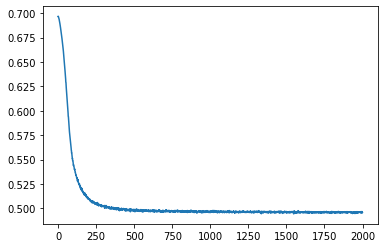

In [123]:
import matplotlib.pyplot as plt

x = list(range(2000))
plt.plot(x, losses)

In [124]:
pred_score = []
for i in range(len(pt_lr)):
    embedding = bert_model.encode([pt_lr['cleaned_job_title'][i]])
    embedding_tensor = torch.from_numpy(embedding).float()
    pred = round(rank_model.predict(embedding_tensor).detach().numpy().sum(),2)
    pred_score.append(pred)

pt_lr['RankNet_score'] = pred_score
pt_lr.sort_values(by ='RankNet_score', ascending = False)

,id,job_title,location,connection,cleaned_job_title,tfidf_sim_score,GloVe_sim_score,Word2Vec_sim_score,BERT_sim_score,mean_sim_score,starred_score,RankNet_score
12,27,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,aspiring human resource management student seeking internship,0.428269,0.881137,0.783973,0.702358,0.698934,0.698934,1.00
27,79,Liberal Arts Major. Aspiring Human Resources Analyst.,"Baton Rouge, Louisiana Area",7,liberal art major aspiring human resource analyst,0.350196,0.850251,0.731783,0.557963,0.622548,0.622548,1.00
22,74,Human Resources Professional,Greater Boston Area,16,human resource professional,0.397849,0.933199,0.874494,0.809261,0.753701,0.753701,1.00
21,73,"Aspiring Human Resources Manager, seeking internship in Human Resources.","Houston, Texas Area",7,aspiring human resource manager seeking internship human resource,0.609698,0.934672,0.875945,0.752413,0.793182,0.793182,1.00
20,72,Business Management Major and Aspiring Human Resources Manager,"Monroe, Louisiana Area",5,business management major aspiring human resource manager,0.425993,0.812279,0.760062,0.607583,0.651479,0.651479,1.00
30,82,Aspiring Human Resources Professional | An energetic and Team-Focused Leader,"Austin, Texas Area",174,aspiring human resource professional energetic teamfocused leader,0.373958,0.895589,0.827266,0.867910,0.741181,1.000000,1.00
36,88,Human Resources Management Major,"Milpitas, California",18,human resource management major,0.244574,0.835959,0.734347,0.685756,0.625159,0.625159,1.00
16,68,Human Resources Specialist at Luxottica,Greater New York City Area,500+,human resource specialist luxottica,0.223960,0.814814,0.741441,0.715959,0.624043,0.624043,1.00
15,67,"Human Resources, Staffing and Recruiting Professional","Jackson, Mississippi Area",500+,human resource staffing recruiting professional,0.195859,0.848083,0.706574,0.714154,0.616167,0.616167,1.00
14,66,Experienced Retail Manager and aspiring Human Resources Professional,"Austin, Texas Area",57,experienced retail manager aspiring human resource professional,0.404718,0.833745,0.779507,0.656641,0.668653,0.668653,1.00
